# Farm record-keeping in farmOS via OpenAPI Is it feasible?
_exploring the possibilities, and the constraints_

## Farm Record-Keeping Context
The following Use Case Diagram illustrates the flow of data related to this farm operation:

![Use Case Diagram](https://trello-attachments.s3.amazonaws.com/59f1fb4bb19910c6c6a4367f/5d525f2e59b77812de3869d8/60ac32f649e3afd58602f41d0682bf2b/Farm_Data_Processing.jpeg)

... which is probably a pretty typical farm record-keeping dataflow, in essence.  The UseCase we aim to address in this iteration is based on the following User Story (from the actor depicted in LL of above diagram):

-   **"In my Role as PM:OMG (Production Manager for the Organic Market Garden), the harvest data that i gather 2x /week from the OMG team in spreadsheet form needs to be uploaded to farmOS on a weekly basis with as little friction as possible."**


## Focus ;  Research Question(s)
This UseCase, and some of the complications about it is further elaborated in [this thread from farmOS Discourse forum](https://farmos.discourse.group/t/csv-importers-in-v2-x/942) ; the essence of the problem lies in these two facts: 

* Crop Plan and Harvest Log data is being collected in spreadsheets; and
* There is at present no "Import CSV" feature in v2 of farmOS.

therefore- until there is an "Import CSV" facility developed for farmOS v2.x- such data collected in spreadsheets can only be uploaded via the API.  The canonical methods for such script access are [published to the project repository as farmOS.py](https://github.com/farmOS/farmOS.py), which can be loaded here via !pip command, but comprehensive testing of its functions have yet to be performed.

**QUESTION(S) for Research:**
1. Is it feasible to deploy a tool for API access to farm staff, in a form that is usable enough to fit into weekly farm workflow?
1. Is it possible to upload files of both Crop Plan (i.e. "Plant asset") and Harvest Log type via API, such that both POST of new records and PUT (update) on existing records is done in a way that is transparent to the user?
1. Database Referential Integrity: Is it possible via the "Name" field that identifies Plant assets uniquely, to maintain links between Harvest logs and the Plant asset to which they pertain?

# CSV Data Collection + Preliminary EDA

In [ ]:
# import needed libraries, and check versions
import numpy as np
import pandas as pd   #load the software
print("Pandas version ",pd.__version__)  # confirm software version, to guarantee reproducible results
print("Numpy version ",np.__version__)

Pandas version  1.3.5
Numpy version  1.21.5


In [ ]:
# Import the .csv datafile of Plant assets (crops) and eyeball a few
df=pd.read_csv("/content/CROPS.csv")
# do hi-level overview
print("Number of Rows, Columns = ",df.shape)  #to know the depth & scope of dataframe
print("Column Headers: ",df.columns)  # to see names of column headers
print("Datatype of index = ",type(df.index[0]))  # to confirm datatype of the index

Number of Rows, Columns =  (213, 8)
Column Headers:  Index(['Name', 'Archived', 'Description', 'Parent IDs', 'Parent names',
       'Crop/variety', 'Season', 'Area/Location'],
      dtype='object')
Datatype of index =  <class 'int'>


In [ ]:
df.head()

,Name,Archived,Description,Parent IDs,Parent names,Crop/variety,Season,Area/Location
0,2021-W20 Carrot HVE01,NaN,Length (m): 55.2; Nr of plants: 11040,NaN,NaN,Carrot,SPRING,HortasDoVale-East (HDVE) - bed 1
1,2021-W50 Lettuce HVE01-N,NaN,Length (m): 55.2; Nr of plants: 11040,NaN,NaN,Lettuce,WINTER,HortasDoVale-East (HDVE) - bed 1 north section
2,2021-W22 Carrot HVE02,NaN,Length (m): 55.2; Nr of plants: 11040,NaN,NaN,Carrot,SPRING,HortasDoVale-East (HDVE) - bed 2
3,2021-W38 Carrot HVE03,NaN,Length (m): 27.6; Nr of plants: 27,NaN,NaN,Carrot,AUTUMN,HortasDoVale-East (HDVE) - bed 3
4,2021-W24 Sweet potato HVE04-N,NaN,Length (m): 27.6; Nr of plants: 27,NaN,NaN,Sweet potato,SUMMER,HortasDoVale-East (HDVE) - bed 4 north section


In [ ]:
# for a more agile/ interactive view of the Pandas dataframe, load gColab's "Interactive Data Table" extension
%load_ext google.colab.data_table
df

,Name,Archived,Description,Parent IDs,Parent names,Crop/variety,Season,Area/Location
0,2021-W20 Carrot HVE01,NaN,Length (m): 55.2; Nr of plants: 11040,NaN,NaN,Carrot,SPRING,HortasDoVale-East (HDVE) - bed 1
1,2021-W50 Lettuce HVE01-N,NaN,Length (m): 55.2; Nr of plants: 11040,NaN,NaN,Lettuce,WINTER,HortasDoVale-East (HDVE) - bed 1 north section
2,2021-W22 Carrot HVE02,NaN,Length (m): 55.2; Nr of plants: 11040,NaN,NaN,Carrot,SPRING,HortasDoVale-East (HDVE) - bed 2
3,2021-W38 Carrot HVE03,NaN,Length (m): 27.6; Nr of plants: 27,NaN,NaN,Carrot,AUTUMN,HortasDoVale-East (HDVE) - bed 3
4,2021-W24 Sweet potato HVE04-N,NaN,Length (m): 27.6; Nr of plants: 27,NaN,NaN,Sweet potato,SUMMER,HortasDoVale-East (HDVE) - bed 4 north section
...,...,...,...,...,...,...,...,...
208,2021-W14 Tomato small WGH06,NaN,Length (m): ; Nr of plants:,NaN,NaN,Tomato small,SPRING,Winter Green House - bed 6
209,2021-W14 Tomato roma WGH06,NaN,Length (m): ; Nr of plants:,NaN,NaN,Tomato roma,SPRING,Winter Green House - bed 6
210,2021-W47 Salanova WGH06,NaN,Length (m): ; Nr of plants:,NaN,NaN,Salanova,AUTUMN,Winter Green House - bed 6
211,2021-W47 Lettuce WGH06,NaN,Length (m): ; Nr of plants:,NaN,NaN,Lettuce,AUTUMN,Winter Green House - bed 6


## Exploring the data frame
NB:  This "Interactive Data Table" extension brings useful functionality- see how you can Sort on any column, set any combination of Filters, adjust Pagination, etc. -but such functions may not accompany this .ipynb file to its deployment in other tools in the Jupyter ecosystem.

## Visualizing the data

Given the range of libraries available in this tool, virtually any sort of visualisation can be implemented, ranging from a simpe Pie Chart (below) to Dynamic & Interactive visualisation demonstrated at end of this document.

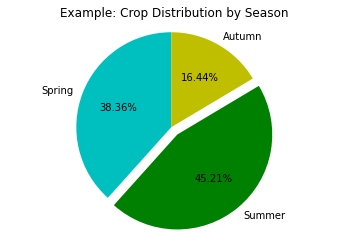

In [ ]:
# start with a simple pie-chart of crop distribution by season, based on this pie-chart example
import matplotlib.pyplot as plt

labels = 'Spring', 'Summer', 'Autumn'
sections = [56, 66, 24]
colors = ['c', 'g', 'y']

plt.pie(sections, labels=labels, colors=colors,
        startangle=90,
        explode = (0, 0.1, 0),
        autopct = '%1.2f%%')

plt.axis('equal') # Try commenting this out.
plt.title('Example: Crop Distribution by Season')
plt.show()

# Test the API for essential interactions
Essential operations to test, in order:
1. Obtain credentials to interact with API
1. GET whatever data we need, before we proceed to
1. PUT updates to existing records, or POST new data.

In [ ]:
!pip install farmOS==1.0.0b3

     |████████████████████████████████| 10.9 MB 4.6 MB/s 


## API Access: grant of credentials

As a precondition of access, it is necessary to get an OAuth token from the server; this token must be periodically refreshed according to some present parameter....

Moreover: to protect integrity of the database, it is important that credentials be sent across the wire in secure fasion...

In [ ]:
from farmOS import farmOS #load the library
hostname="https://vdl.farmos.dev"
farm_client = farmOS(hostname=hostname, client_id="farm", scope="farm_manager") #login
current_token = farm_client.authorize(username="apiTest", password="api+35+erAPI") #get OAuth token
farm_client.info() #poll API for endpoints

{'data': [],
 'jsonapi': {'meta': {'links': {'self': {'href': 'http://jsonapi.org/format/1.0/'}}},
  'version': '1.0'},
 'links': {'asset--animal': {'href': 'https://vdl.farmos.dev/api/asset/animal'},
  'asset--equipment': {'href': 'https://vdl.farmos.dev/api/asset/equipment'},
  'asset--group': {'href': 'https://vdl.farmos.dev/api/asset/group'},
  'asset--land': {'href': 'https://vdl.farmos.dev/api/asset/land'},
  'asset--plant': {'href': 'https://vdl.farmos.dev/api/asset/plant'},
  'asset--sensor': {'href': 'https://vdl.farmos.dev/api/asset/sensor'},
  'asset--structure': {'href': 'https://vdl.farmos.dev/api/asset/structure'},
  'asset_type--asset_type': {'href': 'https://vdl.farmos.dev/api/asset_type/asset_type'},
  'data_stream--basic': {'href': 'https://vdl.farmos.dev/api/data_stream/basic'},
  'data_stream_type--data_stream_type': {'href': 'https://vdl.farmos.dev/api/data_stream_type/data_stream_type'},
  'entity_browser--entity_browser': {'href': 'https://vdl.farmos.dev/api/enti

## Test GET functionality

In [ ]:
# logs = list(farm_client.log.iterate('harvest'))
harvest = farm_client.log.get('harvest')
harvest
len(harvest['data'])

5

In [ ]:
# crops = list(farm_client.asset.iterate('plant'))
crops = farm_client.asset.get('plant')
crops
len(crops['data'])

50

In [ ]:
# observations = list(farm_client.log.iterate('observation'))
observations = farm_client.log.get('observation')
observations
len(observations['data'])

50

In [ ]:
# land = list(farm_client.asset.iterate('land'))
land = farm_client.asset.get('land')
land
len(land['data'])

50

In [ ]:
harvest

## Test PUT functionality

This is the tricky bit: to be able to upload CSV files such that existing records will be updated (i.e. a PUT call) and only new records will be POSTed, such that no duplicate records are created. 

Moreover: w/r/t Harvest logs need always to refer to the Plant asset on which they are acting- and not just once; most Plant assets will support many Harvest events- so that the related files can be pulled in a single query.

In [ ]:
# Create observation log
observation_log = {
    "attributes": {
        "name": "2022-W07 WOMpost Chipper in NSDZ",
        "status": "done",
        "flag" : "priority",
        "notes": "The chipper came this week; all landscaper cuttings in North Slope Deposition Zone fully processed."       
    } 
}
# log = farm_client.log.send('observation', observation_log). COMMENTED OUT, BECAUSE- ONCE SENT -IT WOULD CREATE DUPLICATE RECORDS

# Filter to 'priority' logs.
filters = farm_client.filter('flag', 'priority')
response = farm_client.log.get('observation', params=filters)
response

{'data': [{'attributes': {'changed': '2022-02-18T18:04:47+00:00',
    'created': '2022-02-18T18:04:47+00:00',
    'data': None,
    'default_langcode': True,
    'drupal_internal__id': 749,
    'drupal_internal__revision_id': 980,
    'flag': ['priority'],
    'geometry': None,
    'is_group_assignment': None,
    'is_movement': False,
    'langcode': 'en',
    'name': '2022-W07 WOMpost Chipper in NSDZ',
    'notes': {'format': None,
     'processed': '<p>The chipper came this week; all landscaper cuttings in North Slope Deposition Zone fully processed.</p>\n',
     'value': 'The chipper came this week; all landscaper cuttings in North Slope Deposition Zone fully processed.'},
    'revision_created': '2022-02-18T18:04:47+00:00',
    'revision_log_message': None,
    'revision_translation_affected': True,
    'status': 'done',
    'timestamp': '2022-02-18T18:04:47+00:00'},
   'id': 'd9b16c80-981e-490f-b571-c86555251bff',
   'links': {'self': {'href': 'https://vdl.farmos.dev/api/log/obse

## Limitations & Questions

As demonstrated via the "Observation log" code block just above, there are some limitations to be aware of, which gives rise to some questions:

1. One can't simply change a parameter or add an attribute (as done with the "priority" flag in above) and thereby create an update to the so-named record; each SEND request creates a new record.
1. It is not clear from the ["Client Methods" HowTo for this script](https://github.com/farmOS/farmOS.py/blob/1.x/docs/client_2x.md) how to upload a photo as part of an Observation log.
1. ... 



# Test the Interface for Usability
To create a sustainable data workflow, it is important that farm staff be able to perform key functions with relative ease, including:
1. Upload Plant asset CSV (an occasional operation)
1. Upload Harvest log CSV (weekly operation)
1. Access desired information about plantations and harvests

There is yet to be a GUI interface deployed for API access to a farmOS instance, but this .ipynb Notebook is an exploratory step in that direction, and may be with some additional work rendered sufficient to the purpose.  

## Upload & Download standard reports

## Create a Custom Data Visualisation

To illustrate this function, what follows is an interactive data visualization from the Gapminder Institute, exploring the connection between Life Span (y-axis) and Wealth (x-axis) per Country (bubble) and Continent (color), and how those relative positions have changed over the years from 1952-2007.  This visualisation runs in a dynamic player, which can be filtered by span of years and by continent, so you can easier explore values for each individual country.

In context of an individual farm, a more relevant instantiation of this visualisation frame would be to see how production & consumption of crops (bubbles) and crop families (colors) rises and falls in volume across seasons of the year.  A visualisation TBD!



In [ ]:
import plotly.express as px
gapminder_df = px.data.gapminder()


In [ ]:
gapminder_df

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
0,Afghanistan,Asia,1952,28.801,8425333,779.445314,AFG,4
1,Afghanistan,Asia,1957,30.332,9240934,820.853030,AFG,4
2,Afghanistan,Asia,1962,31.997,10267083,853.100710,AFG,4
3,Afghanistan,Asia,1967,34.020,11537966,836.197138,AFG,4
4,Afghanistan,Asia,1972,36.088,13079460,739.981106,AFG,4
...,...,...,...,...,...,...,...,...
1699,Zimbabwe,Africa,1987,62.351,9216418,706.157306,ZWE,716
1700,Zimbabwe,Africa,1992,60.377,10704340,693.420786,ZWE,716
1701,Zimbabwe,Africa,1997,46.809,11404948,792.449960,ZWE,716
1702,Zimbabwe,Africa,2002,39.989,11926563,672.038623,ZWE,716


In [ ]:
px.scatter(data_frame=gapminder_df,
           x='gdpPercap',
           y='lifeExp',
           size='pop',
           color='continent',
           title='Life Span and Wealth 1952 - 2007',
           labels={'gdpPercap': 'Wealth','lifeExp':  'Life Span'},
           log_x=True,
           range_y=[25,95],
           hover_name='country',
           animation_frame='year',
           height=600,
           size_max=100)


# farmOS Importers

## About

The crop importer imports the crop_plan_YYYY.csv files. A plant asset and transplanting log into the specified location is created for each row of this CSV file.

(Walt feel free to provide more background if needed)

The crop_plan_2021.csv included some length quantity information, but the 2022.csv file did not have this data. I left the logic for importing these values below in the importer.


## Client configuration

Configure authentication with the farmOS instance.

In [ ]:
!pip install farmOS==1.0.0b3
from farmOS import farmOS
hostname="https://vdl.farmos.dev"
client = farmOS(hostname, client_id="farm", scope="farm_manager")
#current_token = client.authorize(username="apiTest", password="api+35+erAPI")
current_token = client.authorize()


     |████████████████████████████████| 10.9 MB 7.1 MB/s 
Enter username: ··········
Enter password: ··········


## Common helper functions

Helper functions that the CSV import scripts use.

In [ ]:
# Define a couple helper functions to use in the importer script below.
def _get_existing_asset_by_name(asset_type, asset_name):
    """
    Helper function to laod an existing asset by name.
    :param asset_type: The asset type to lookup, eg: plant.
    :param asset_name: The asset name to lookup.
    :return: The asset data or None if not found.
    """

    asset_filter = client.filter('name', asset_name)
    assets = list(client.asset.iterate(asset_type, asset_filter))

    if (len(assets) == 0):
        return None
    else:
        return assets[0]

def _get_or_create_taxonomy_term(vocabulary, term_name):
    """
    Helper function to load an existing or create a new taxonomy term by name.
    :param vocabulary: The taxonomy vocabulary.
    :param term_name: The term name.
    :return: The term data or None if not found.
    """

    term_filter = client.filter('name', term_name)
    terms = list(client.resource.iterate('taxonomy_term', vocabulary, term_filter))

    # Return the first matching term.
    if (len(terms) > 0):
        return terms[0]
    # Else create a new term.
    else:
        term = {
            "attributes": {
                "name": term_name,
            },
        }
        new_term = client.term.send(vocabulary, term)
        return new_term["data"]


## Crop importer

In [ ]:
import logging
import re
import csv
from datetime import datetime
from time import time

# Specify the file path.
file_path = '/content/sample_data/crop_plan_paul_test.csv'

# Prompt the user to avoid running multiple times.
res = input(f"Import crop data from file: {file_path}")

if res is 'y' or res is 'yes':
    print('importing')

    # Open the CSV file.
    with open(file_path, newline='') as csv_file:
        # Iterate through each row of the CSV file.
        reader = csv.DictReader(csv_file, delimiter=',')
        for row in reader:

            # Required values.
            asset_name = row['Name']
            existing_asset = _get_existing_asset_by_name('plant', asset_name)
            if existing_asset is not None:
                print(f"Row {reader.line_num}: Asset already exists: '{asset_name}'")
                continue
            if (asset_name is None or len(asset_name) == 0):
                print(f"Row {reader.line_num}: No asset name")
                continue
            crop_variety = row['Crop/variety']
            if (crop_variety is None or len(crop_variety) == 0):
                print(f"Row {reader.line_num}: No Crop/variety")
                continue
            asset_location_name = row['Area/Location']
            if (asset_location_name is None or len(asset_location_name) == 0):
                print(f"Row {reader.line_num}: No asset location")
                continue

            asset_location = _get_existing_asset_by_name('land', asset_location_name)
            if (asset_location is None):
                print(f"Row {reader.line_num}: Could not find existing location: '{asset_location_name}'")
                continue

            new_asset_data = {
                "attributes": {
                    "type": "plant",
                    "status": 'active' if len(row['Archived']) == 0 else 'archived',
                    "name": asset_name,
                    "notes": row['Description'],
                },
                "relationships": {
                }
            }

            plant_type = _get_or_create_taxonomy_term("plant_type", crop_variety)
            new_asset_data["relationships"]["plant_type"] = {
                "data": [
                    {
                        "type": "taxonomy_term--plant_type",
                        "id": plant_type["id"],
                    }
                ]
            }

            season_value = row['Season']
            if len(season_value) != 0:
                season = _get_or_create_taxonomy_term("season", season_value)
                new_asset_data["relationships"]["season"] = {
                    "data": [
                        {
                            "type": "taxonomy_term--season",
                            "id": season["id"]
                        }
                    ]
                }

            # Create the asset.
            new_asset = client.asset.send('plant', new_asset_data)

            # Load log values.

            # Convert date string to timestamp.
            now = time()
            pattern = r"\d{4}[-][W]\d{1,2}"
            year_week = re.match(pattern, asset_name)
            timestamp = datetime.strptime(year_week.group(0) + '-1', '%Y-W%W-%w').timestamp()

            # Log status
            #raw_status = int(row['Done'])
            #status = "done" if raw_status == 1 else "pending"
            # TODO Calculate status from the date.
            status = "done"

            # Notes
            # TODO build notes from quantities.
            #notes = row['Notes']

            # Create the transplanting log referencing the plant asset.
            log = {
                "attributes": {
                    "timestamp": timestamp,
                    "status": status,
                    #"notes": notes,
                    "is_movement": True,
                },
                "relationships": {
                    "asset": {
                        "data": [
                            {
                                "type": "asset--plant",
                                "id": new_asset["data"]["id"],
                            }
                        ]
                    },
                    "location": {
                        "data": [
                            {
                                "type": "asset--land",
                                "id": asset_location["id"],
                            }
                        ]
                    }
                }
            }

            # Create a quantity for the log if length is provided.
            if 'length FB' in row:
                length_fb = row['length FB']
                nr_plants_fb = row['Nr plants FB']
                if all(len(x) != 0 for x in [length_fb, nr_plants_fb]):
                    length_quantity_data = {
                        "attributes": {
                            "type": "standard",
                            "measure": "length",
                            "value": {
                                "numerator": length_fb,
                                "denominator": 1,
                            },
                            "label": "Length FB",
                        },
                        "relationships": {
                        }
                    }
                    # Create the quantity.
                    length_quantity = client.resource.send('quantity', 'standard', length_quantity_data)

                    count_quantity_data = {
                        "attributes": {
                            "type": "standard",
                            "measure": "count",
                            "value": {
                                "numerator": nr_plants_fb,
                                "denominator": 1,
                            },
                            "label": "Nr plants FB",
                        },
                        "relationships": {
                        }
                    }
                    count_quantity = client.resource.send('quantity', 'standard', count_quantity_data)

                    # Add quantity to log.
                    log["relationships"]["quantity"] = {
                        "data": [
                            {
                                "type": "quantity--standard",
                                "id": length_quantity["data"]["id"],
                                "meta": {
                                    "target_revision_id": length_quantity["data"]["attributes"]["drupal_internal__revision_id"]
                                }
                            },
                            {
                                "type": "quantity--standard",
                                "id": count_quantity["data"]["id"],
                                "meta": {
                                    "target_revision_id": count_quantity["data"]["attributes"]["drupal_internal__revision_id"]
                                }
                            }
                        ]
                    }

            new_log = client.log.send("transplanting", log)

            link = "{hostname}/asset/{id}".format(hostname=hostname,
                                                  id=new_asset["data"]["attributes"]["drupal_internal__id"])
            print(
                "Imported log for asset: {name} - {link}".format(name=new_asset["data"]["attributes"]["name"],
                                                                  link=link))


Import crop data from file: /content/sample_data/crop_plan_paul_test.csvy
importing
Row 2: No Crop/variety


## Harvest importer

In [ ]:
import logging
import re
import csv
from datetime import datetime
from time import time

# Specify the file path.
file_path = '/content/sample_data/log_farm_harvest_week43_dev.csv'

# Prompt the user to avoid running multiple times.
res = input(f"Import harvest data from file: {file_path}")

if res is 'y' or res is 'yes':
    print('importing')

    # Open the CSV file.
    with open(file_path, newline='') as csv_file:
        # Iterate through each row of the CSV file.
        reader = csv.DictReader(csv_file, delimiter=',')
        for row in reader:

            # Required values.
            log_name = row['Log name']
            if (log_name is None or len(log_name) == 0):
                print(f"Row {reader.line_num}: No log name")
                continue
            date = row['Date']
            if (date is None or len(date) == 0):
                print(f"Row {reader.line_num}: No date")
                continue

            asset_name = row['Asset names']
            if (asset_name is None or len(asset_name) == 0):
                print(f"Row {reader.line_num}: No asset name")
                continue
            plant_asset = _get_existing_asset_by_name('plant', asset_name)
            if (plant_asset is None):
                print(f"Row {reader.line_num}: Could not find existing plant asset: '{asset_name}'")
                continue

            # Load log values.

            # Convert date string to timestamp.
            now = time()
            timestamp = datetime.strptime(date, '%Y-%m-%d').timestamp()

            # Log status
            raw_status = int(bool(row['Done']))
            status = "done" if raw_status == 1 else "pending"

            # Notes
            notes = row['Notes']

            # Create the transplanting log referencing the plant asset.
            log = {
                "attributes": {
                    "type": "harvest",
                    "timestamp": timestamp,
                    "status": status,
                    "name": log_name,
                    "notes": notes,
                },
                "relationships": {
                    "asset": {
                        "data": [
                            {
                                "type": "asset--plant",
                                "id": plant_asset["id"],
                            }
                        ]
                    },
                }
            }

            # Add category.
            category = row["Categories"]
            if len(category) != 0:
                category_term = _get_or_create_taxonomy_term("log_category", category)
                log["relationships"]["category"] = {
                    "data": {
                        "type": "taxonomy_term--log_category",
                        "id": category_term["id"],
                    }
                }

            # Add lot number.
            lot_number = row["Lot number"]
            if len(lot_number) != 0:
                log["attributes"]["lot_number"] = lot_number

            # Create a quantity for the log.
            quantity_value = row['Quantity value']
            if len(quantity_value) != 0:
                decimal = float(quantity_value.replace(",", "."))
                harvest_quantity_data = {
                    "attributes": {
                        "type": "standard",
                        "measure": "weight",
                        "value": {
                            "decimal": decimal,
                        },
                    },
                    "relationships": {
                    }
                }

                unit = row["Quantity unit"]
                if len(unit) != 0:
                    unit_term = _get_or_create_taxonomy_term("unit", unit)
                    harvest_quantity_data["relationships"]["units"] = {
                        "data": {
                            "type": "taxonomy_term--unit",
                            "id": unit_term["id"],
                        }
                    }

                # Create the quantity.
                harvest_quantity = client.resource.send('quantity', 'standard', harvest_quantity_data)

                # Add quantity to log.
                log["relationships"]["quantity"] = {
                    "data": [
                        {
                            "type": "quantity--standard",
                            "id": harvest_quantity["data"]["id"],
                            "meta": {
                                "target_revision_id": harvest_quantity["data"]["attributes"]["drupal_internal__revision_id"]
                            }
                        },
                    ]
                }

            new_log = client.log.send("harvest", log)

            link = "{hostname}/log/{id}".format(hostname=hostname,
                                                  id=new_log["data"]["attributes"]["drupal_internal__id"])
            print(
                "Imported log for asset: {name} - {link}".format(name=asset_name,
                                                                  link=link))

Import harvest data from file: /content/sample_data/log_farm_harvest_week43_dev.csvy
importing
Imported log for asset: 2021-W34 Tomatoes varied WGH01 - https://vdl.farmos.dev/log/780
Row 3: Could not find existing plant asset: '2021-W14 Tomatoes varied WGH06'
